In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from keras.models import Model
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import int_shape
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [60]:
#Load tfds dataset
ds, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
test = ds['test']
train = ds['train']
validation = ds['validation']

#Dataset split sizes
train_size = train.cardinality()
print("Test size:", test.cardinality())
print("Train size", train_size)
print("Validation size", validation.cardinality())

Test size: tf.Tensor(6149, shape=(), dtype=int64)
Train size tf.Tensor(1020, shape=(), dtype=int64)
Validation size tf.Tensor(1020, shape=(), dtype=int64)


In [61]:
#Number of flower classes
num_classes = info.features['label'].num_classes
print("Number of flower classes:", num_classes)

Number of flower classes: 102


In [62]:
#Getting the shape of the images. None = varies in size in height and width. Depth = 3 meaning RGB 3 channel image
print(info.features['image'].shape)

(None, None, 3)


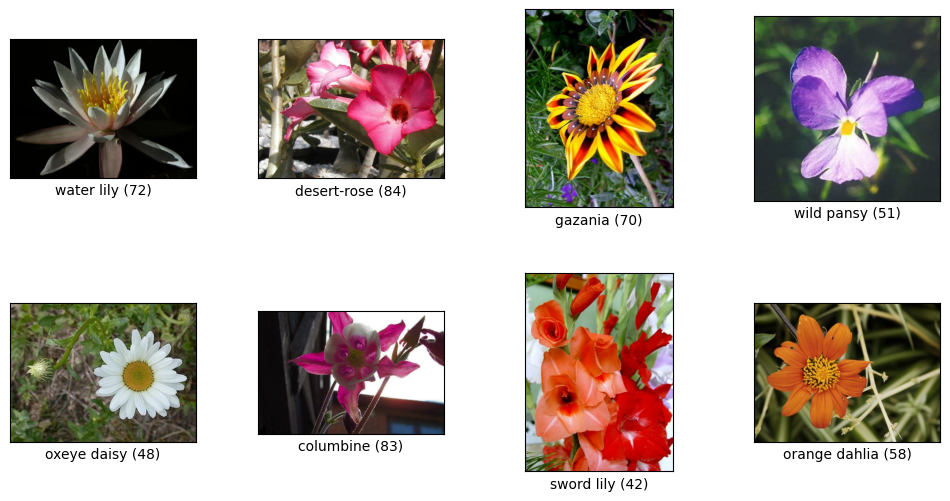

Figure(1200x600)


In [63]:
#Showing some examples of the ds with varying image size and classes
print(tfds.show_examples(train, info, rows=2, cols=4))

In [64]:
batch_size = 256
image_size = 128

def crop_and_resize_image(image, label):
  shape = tf.shape(image)
  #[-1] index is the image channel
  height = shape[-3]
  width = shape[-2]

  #takes shortest dimension and crops square
  if height > width:
      image = tf.image.crop_to_bounding_box(image, offset_height=(height - width) // 2, offset_width=0, target_height=width, target_width=width)
  else:
      image = tf.image.crop_to_bounding_box(image, offset_height=0, offset_width=(width - height) // 2, target_height=height, target_width=height)

  # shortest = tf.math.minimum(height, width)
  # image = tf.image.random_crop(image, (shortest, shortest, 3))

  #downsample image
  image = tf.image.resize(image, (image_size, image_size), antialias=True)/255.0
  return image, label
test_batches = test.map(crop_and_resize_image).batch(batch_size)
train_batches = train.cache().shuffle(train_size, reshuffle_each_iteration=True).repeat(60).map(crop_and_resize_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_batches = validation.cache().map(crop_and_resize_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

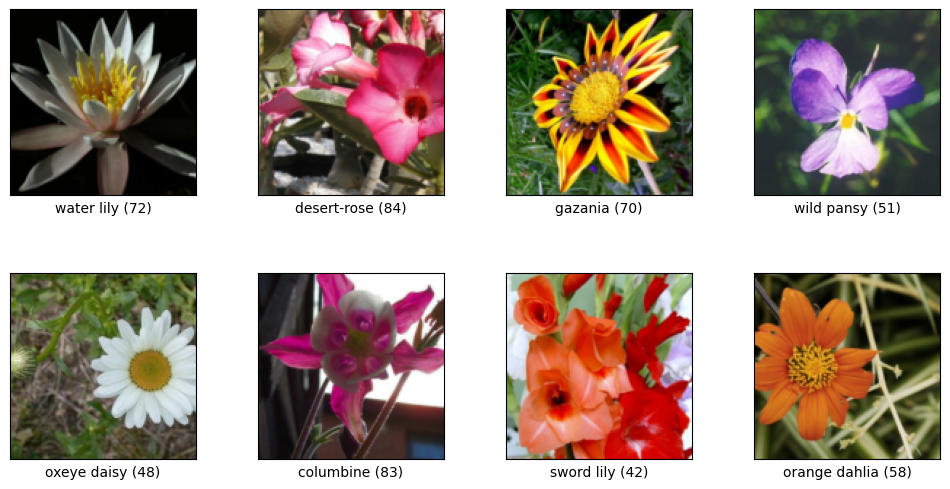

Figure(1200x600)


In [65]:
#Showing some examples of the cropped and resized ds
temp = train.cache().map(crop_and_resize_image)
print(tfds.show_examples(temp, info, rows=2, cols=4))

In [66]:
#Data augmentation

data_augmentation = keras.Sequential([
  layers.RandomContrast(0.5),
  layers.RandomBrightness(0.2, value_range=(0, 1)),
  layers.RandomFlip("horizontal_and_vertical"),
  # layers.RandomTranslation(0.2, 0.2, fill_mode='reflect'),
  # layers.RandomZoom(0.3, fill_mode='reflect'),
  layers.RandomRotation(0.2)
])



In [67]:
# #Defining our model with its layers
# model = keras.Sequential([
#     data_augmentation,
#     layers.Conv2D(16, 3, strides=1, padding='same', activation='relu', kernel_constraint=max_norm(3.)),
#     layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
#     layers.Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_constraint=max_norm(3.)),
#     layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
#     layers.Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_constraint=max_norm(3.)),
#     layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
#     layers.Flatten(),
#     layers.Dense(1024, activation='relu', kernel_constraint=max_norm(3.)),
#     layers.Dropout(0.5),
#     layers.Dense(num_classes, activation='softmax')
# ])

In [68]:
#Resnet model
'''
def residual(input_layer, n_filters, downsample):
  input = input_layer
  if input.shape[-1] != n_filters:
    input = layers.Conv2D(n_filters, (1,1), strides=(2 if downsample else 1), padding='same', activation='relu', kernel_initializer='he_normal')(input_layer)

  conv1 = layers.Conv2D(n_filters, (3,3), strides=(2 if downsample else 1), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(input_layer)
  conv1 = layers.BatchNormalization()(conv1)

  conv2 = layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(conv1)

  output_layer = layers.Add()([conv2, input])
  output_layer = layers.Activation('relu')(output_layer)
  conv2 = layers.BatchNormalization()(conv2)
  return output_layer

def create_residual_model(initial_filters, block_set):
  input_layer = layers.Input(shape=(image_size, image_size, 3))
  n_filters = initial_filters

  x = input_layer
  x = layers.Conv2D(64, (7, 7), strides=2)(x)
  x = layers.MaxPooling2D((3, 3), strides=2)(x)
  for i in range(len(block_set)):
    num_blocks = block_set[i]
    for j in range(num_blocks):
      x = residual(x, n_filters, j==0 and i!=0)
    n_filters = n_filters * 2

  residual_model = Model(inputs=input_layer, outputs=x)
  return residual_model

model = keras.Sequential([
    data_augmentation,
    create_residual_model(64, [2, 2, 2, 2]),
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])
'''

"\ndef residual(input_layer, n_filters, downsample):\n  input = input_layer\n  if input.shape[-1] != n_filters:\n    input = layers.Conv2D(n_filters, (1,1), strides=(2 if downsample else 1), padding='same', activation='relu', kernel_initializer='he_normal')(input_layer)\n\n  conv1 = layers.Conv2D(n_filters, (3,3), strides=(2 if downsample else 1), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(input_layer)\n  conv1 = layers.BatchNormalization()(conv1)\n\n  conv2 = layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(conv1)\n\n  output_layer = layers.Add()([conv2, input])\n  output_layer = layers.Activation('relu')(output_layer)\n  conv2 = layers.BatchNormalization()(conv2)\n  return output_layer\n\ndef create_residual_model(initial_filters, block_set):\n  input_layer = layers.Input(shape=(image_size, image_size, 3))\n  n_filters = initial_filters\n\n  x = input_layer\n  x = laye

In [69]:
# DenseNet Model
def batchReluConv(x,n_filters, k=1, s=1):
  conv = layers.BatchNormalization()(x)
  conv = layers.ReLU()(x)
  conv = layers.Conv2D(n_filters,1, strides=s, padding='same')(conv)
  return conv

def denseBlock(x,repeat,f):
  for _ in range(repeat):
    y = batchReluConv(x,4*f)
    y = batchReluConv(x,f,3)
    x = layers.concatenate([y,x])
  return x

def transitionLayer(x):
  x = batchReluConv(x,int(x.shape[-1]) // 2)
  x = layers.AvgPool2D(2, strides = 2, padding = 'same')(x)
  return x
  
# Creating the Dense Model
def createDenseModel(input_shape,n_filters, f=48):
  input = layers.Input(input_shape)
  x = layers.Conv2D(64,7,strides = 2, padding = 'same')(input)
  x = layers.MaxPool2D(3, strides = 2, padding = 'same')(x)

  n_blocks = [6, 12, 36, 24]

  for i, n_layers in enumerate(n_blocks):
    x = denseBlock(x, n_layers, f)
    if i !=len(n_blocks) - 1:
      x = transitionLayer(x)
        
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)      
  layers.GlobalAvgPool2D()(x),
  output = layers.Dense(n_filters, activation='softmax')(x)

  model = Model(inputs=input, outputs=output)
  return model

model = keras.Sequential([
    data_augmentation,
    layers.InputLayer(input_shape=(image_size, image_size, 3)),
    createDenseModel((image_size, image_size, 3), 64),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

In [70]:
#Compiles our model
model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss=keras.losses.SparseCategoricalCrossentropy(), #Sparse means labels can be integers rather than one-hot enocded
  metrics=['accuracy']
  )

In [71]:
#Adding callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='checkpoint.h5', save_best_only=True, monitor='val_loss'),
    keras.callbacks.EarlyStopping(patience=5)
]

In [72]:
#Train model and store results
num_epochs = 10
train_history = model.fit(x=train_batches, epochs=num_epochs, callbacks=callbacks, validation_data=validation_batches)

Epoch 1/10
240/240 [==============================] - 287s 915ms/step - loss: 3.9584 - accuracy: 0.1104 - val_loss: 4.0430 - val_accuracy: 0.0637
Epoch 2/10
240/240 [==============================] - 215s 893ms/step - loss: 3.3134 - accuracy: 0.1923 - val_loss: 3.6021 - val_accuracy: 0.1461
Epoch 3/10
240/240 [==============================] - 207s 861ms/step - loss: 3.0690 - accuracy: 0.2187 - val_loss: 3.5741 - val_accuracy: 0.1431
Epoch 4/10
240/240 [==============================] - 212s 880ms/step - loss: 2.8751 - accuracy: 0.2541 - val_loss: 3.3736 - val_accuracy: 0.2010
Epoch 5/10
240/240 [==============================] - 211s 878ms/step - loss: 2.7728 - accuracy: 0.2704 - val_loss: 3.3343 - val_accuracy: 0.2059
Epoch 6/10
240/240 [==============================] - 211s 875ms/step - loss: 2.6656 - accuracy: 0.2906 - val_loss: 3.5019 - val_accuracy: 0.1676
Epoch 7/10
240/240 [==============================] - 209s 869ms/step - loss: 2.5705 - accuracy: 0.3086 - val_loss: 3.3860 -

In [73]:
model.evaluate(test_batches)

25/25 [==============================] - 27s 1s/step - loss: 3.4225 - accuracy: 0.2047


[3.4225058555603027, 0.20474873483181]

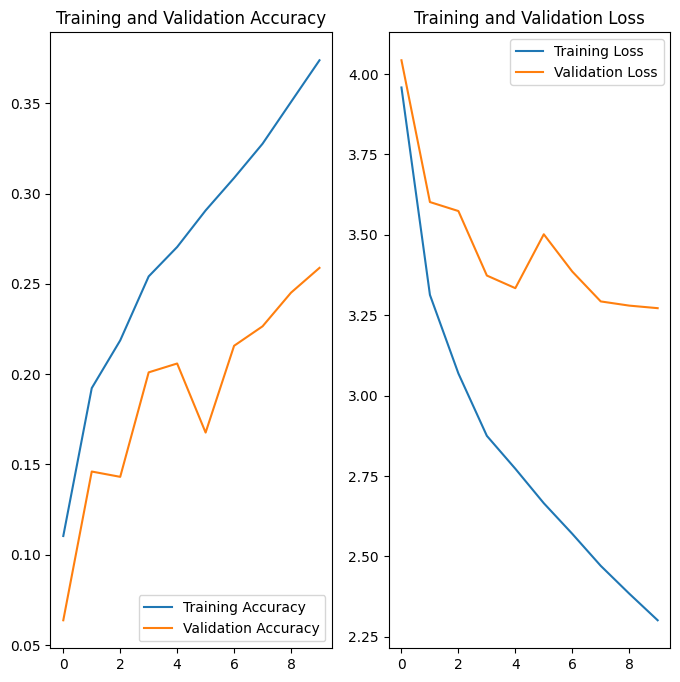

In [74]:
# Creating plots of the loss of accuracy on the training and validation sets
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

epochs_range = range(num_epochs)

# Training and Validation Accuracy
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

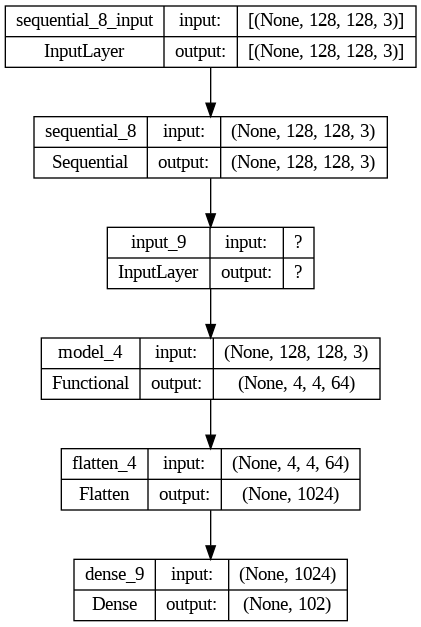

In [75]:
plot_model(model, show_shapes=True, to_file='residual_module.png')

In [76]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 input_9 (InputLayer)        multiple                  0         
                                                                 
 model_4 (Functional)        (None, 4, 4, 64)          6978356   
                                                                 
 flatten_4 (Flatten)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 102)               104550    
                                                                 
Total params: 7,082,906
Trainable params: 7,078,498
Non-trainable params: 4,408
_________________________________________________________________
